In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random
import librosa as lb

Part 1

a) We will program our robot to move according to a Markov chain. There are 11 distinct positions,
corresponding to x = 0, 1, 2,…, 10 meters along a track. When the robot is in position x = 1, 2, …, 9, the
robot will remain in the same position at the next time step with probability 0.8, move to the left at the
next time step with probability 0.1, and move to the right at the next time step with probability 0.1. For
positions x = 0 and x=10, the robot will remain in the current position at the next time step with
probability 0.9 and move away from the boundary at the next time step with probability 0.1. Create the
state transition matrix A and print out its values.

In [9]:
A = 0.8*np.eye(11) + 0.1*np.triu(np.tril(np.ones(11), -1),-1) + 0.1*np.triu(np.tril(np.ones(11), 1),1)
A[0,0] += 0.1
A[-1,-1] += 0.1

b)  Given that the robot starts at position x=5 at time step t=0, simulate the robot’s position over 50
(discrete) time steps. Repeat the simulation 10 times and plot the 10 trajectories in a figure.

In [33]:
def positionSimulator(startingState, numSims, numSteps):
    pos = np.zeros((numSims, numSteps))
    pos[:,0] = startingState
    for i in range(1,numSteps):
        chances = np.random.rand(1,numSims)
        pos[:,i] = pos[:,i-1] - (chances < 0.1) + (chances >= 0.9)
        pos[:,i] = ((pos[:,i] > 0) * pos[:,i]) - (pos[:,i] > 10)
    return pos

In [64]:
def plotSteps(pos):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    
    plt.plot(pos.T)
    plt.title("Robot Steps Over Time")
    plt.show()

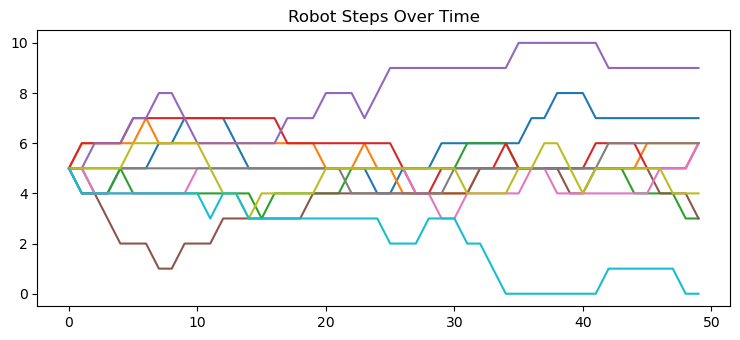

In [65]:
testSteps = positionSimulator(5, 10, 50)
plotSteps(testSteps)

In [66]:
# Define a PMF that acts as the "initial state", indicating that our robot begins at position 5
init_pmf = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
testPMF = init_pmf @ np.linalg.matrix_power(A, 1)

testPMF = [init_pmf @ np.linalg.matrix_power(A, 1), init_pmf @ np.linalg.matrix_power(A, 2), init_pmf @ np.linalg.matrix_power(A, 3)]

In [67]:
def plotPMFs(listPMF):
    xk = np.arange(0, 11)
    pk1, pk2, pk3 = listPMF[0], listPMF[1], listPMF[2]
    
    custm_1 = stats.rv_discrete(name='custm_1', values=(xk, pk1))
    custm_2 = stats.rv_discrete(name='custm_2', values=(xk, pk2))
    custm_3 = stats.rv_discrete(name='custm_3', values=(xk, pk3))

    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
    
    ax1.plot(xk, custm_1.pmf(xk), 'ro', ms=12, mec='r')
    ax1.vlines(xk, 0, custm_1.pmf(xk), colors='r', lw=4)
    ax1.title.set_text('PMF at t=1')
    ax1.set_xlabel('Robot State')

    
    ax2.plot(xk, custm_2.pmf(xk), 'ro', ms=12, mec='r')
    ax2.vlines(xk, 0, custm_2.pmf(xk), colors='r', lw=4)
    ax2.title.set_text('PMF at t=2')
    ax2.set_xlabel('Robot State')
    
    ax3.plot(xk, custm_3.pmf(xk), 'ro', ms=12, mec='r')
    ax3.vlines(xk, 0, custm_3.pmf(xk), colors='r', lw=4)
    ax3.title.set_text('PMF at t=3')
    ax3.set_xlabel('Robot State')
    
    plt.subplots_adjust(wspace=0.5) 
    plt.show()

    
    

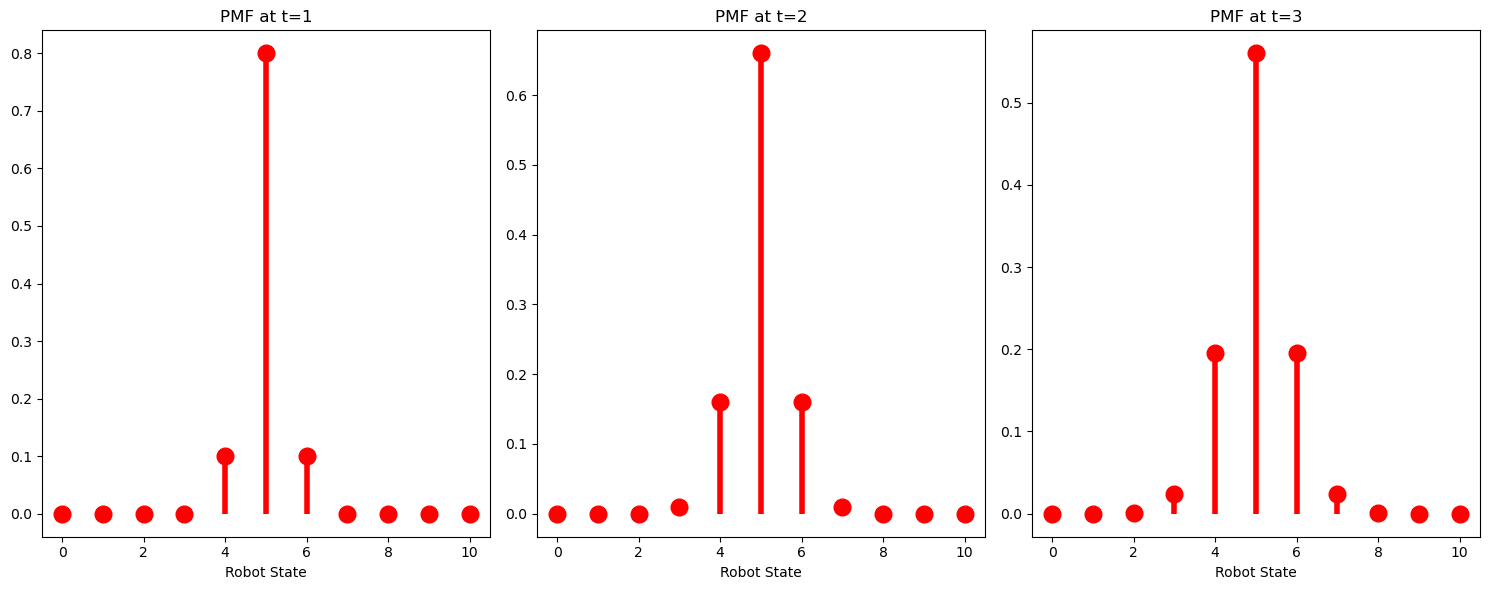

In [68]:
plotPMFs(testPMF)

In [69]:
def findUniform(init_pmf, A, threshold):
    numSteps = 0
    while True:
        numSteps += 1
        outPMF = init_pmf @ np.linalg.matrix_power(A, numSteps)
        max, min = np.max(outPMF), np.min(outPMF)
        if max - min < threshold:
            plt.stem(outPMF)
            plt.title(f'PMF at t={numSteps}')
            plt.xlabel('Robot State')
            return outPMF

array([0.09043326, 0.09058433, 0.09083851, 0.0911151 , 0.09132628,
       0.09140501, 0.09132628, 0.0911151 , 0.09083851, 0.09058433,
       0.09043326])

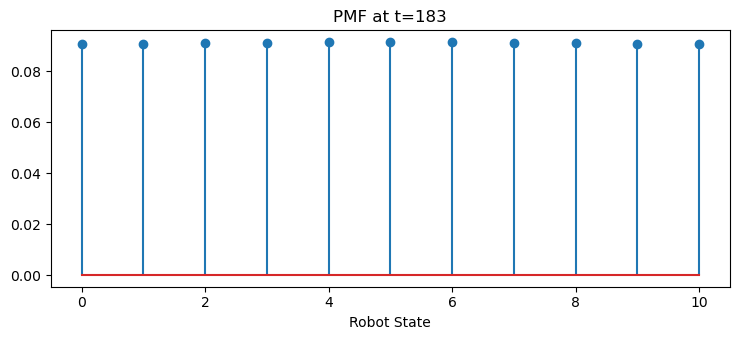

In [70]:
findUniform(init_pmf, A, threshold=0.001)

In [71]:
xt = testSteps[0,:]

In [77]:
noise_levels = [0.4, 1, 2]

In [78]:
nt_1 = np.random.normal(0, noise_levels[0], 50)
nt_2 = np.random.normal(0, noise_levels[1], 50)
nt_3 = np.random.normal(0, noise_levels[2], 50)

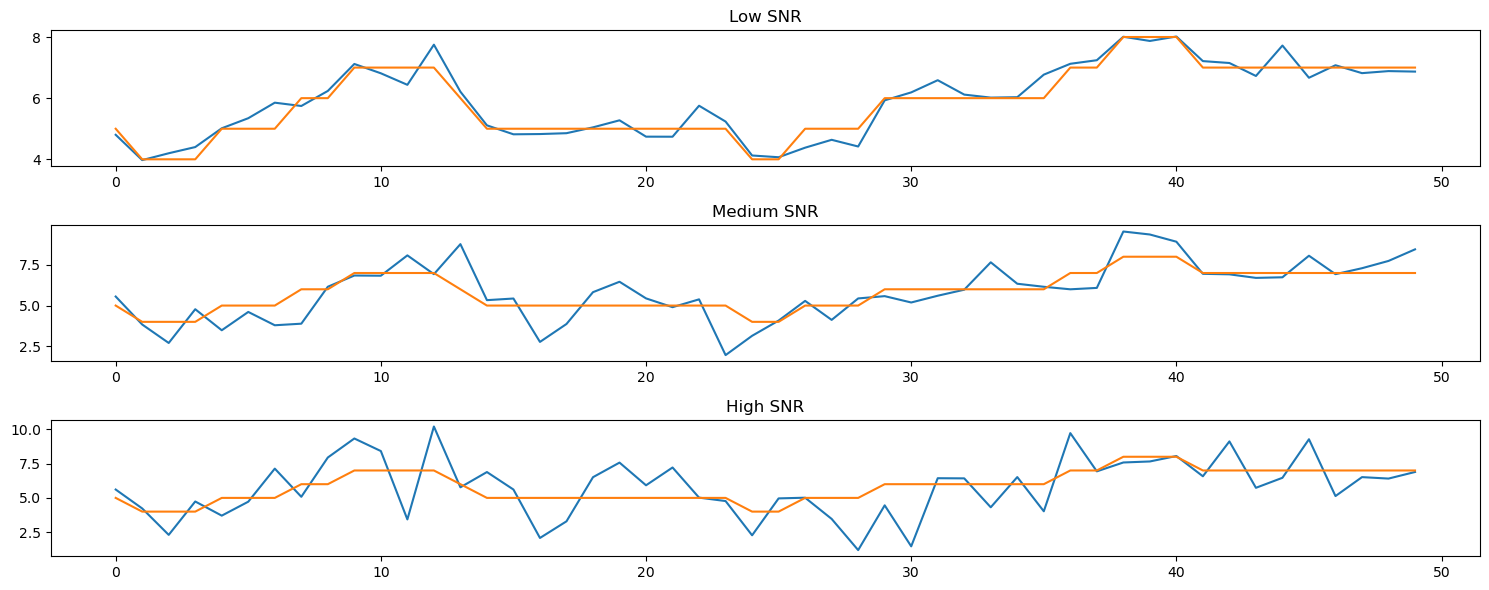

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 6))

ax1.plot(xt + nt_1)
ax1.title.set_text('Low SNR')
ax1.plot(xt)

ax2.plot(xt + nt_2)
ax2.title.set_text('Medium SNR')
ax2.plot(xt)

ax3.plot(xt + nt_3)
ax3.title.set_text('High SNR')
ax3.plot(xt)

plt.show()


In [80]:
def createProbDensityMatrix(observations, n):
    ProbDensityMatrix = np.zeros((11, len(observations)))
    for i in range(11):
        rv = stats.norm(i, n)
        ProbDensityMatrix[i, :] = rv.pdf(observations)
    return ProbDensityMatrix

In [81]:
def plotViterbi(A, observations, n, init_pmf, xt):
    for i in range(3):
        densityMatrix = createProbDensityMatrix(observations[i], n[i])
        viterbi = lb.sequence.viterbi(densityMatrix, A, p_init=init_pmf)
        plt.subplot((311+i))
        plt.plot(viterbi, 'ro')
        plt.plot(xt, 'b-')
        
    plt.show()

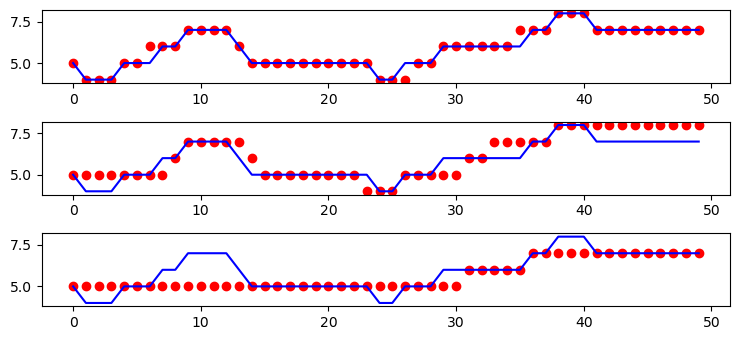

In [82]:
plotViterbi(A, [xt + nt_1, xt + nt_2, xt + nt_3], noise_levels, init_pmf, xt)

# Small noise is making us get errors?

In [83]:
def SNRaccuracy(A, n, init_pmf, xt):
    accuracies = np.zeros(len(n))
    for i in range(len(n)):
        observations = xt+np.random.normal(0, n[i], len(xt))
        densityMatrix = createProbDensityMatrix(observations, n[i])
        viterbi = lb.sequence.viterbi(densityMatrix, A, p_init=init_pmf)
        accuracies[i] = np.sum((np.asarray(viterbi)-np.asarray(xt))==0)/len(observations)
    plt.plot(n, accuracies)
        

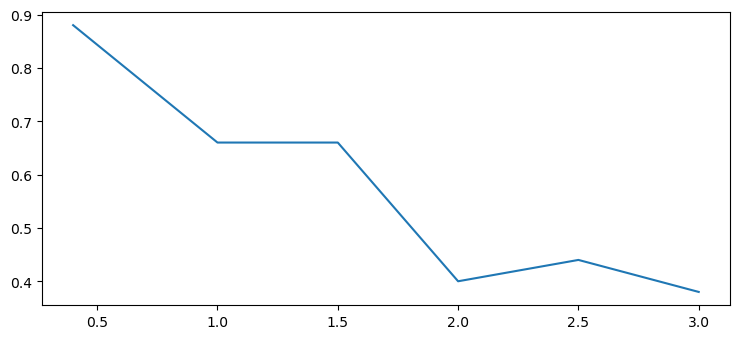

In [92]:
SNRaccuracy(A, [0.4, 1, 1.5, 2, 2.5, 3], init_pmf, xt)